In [5]:
#1


using LinearAlgebra
# an implementation of the primal barrier method.
# this is algorithmic framework 19.5 on page 584.
function barrier(P, ∇P, x, c; μ=1)
    println(norm(∇P(x, μ)))
    while norm(∇P(x,μ)) < 5
        x = steepest_descent_barrier(P, ∇P, x, μ, c)
        if norm(P(x, μ) -((x[1]+0.5)^2 + (x[2]-0.5)^2)) < .01
             return x, μ
        end
         μ = μ-.1
    end
end

# algorithm 3.1 (backtracking line search)
# modified to work with barrier methods
function backtracking_line_search_barrier(f, ∇f, x, μ, c, p)
    α = .5     # initial step length
    rho = 0.75
    ctol = 1e-4
    function stay_feasible(α)
        while c(x + α*p) < 0
            α *= rho
        end
        return α
    end
    α = stay_feasible(α)

    while f(x + α*p, μ) > f(x, μ) + ctol*α*transpose(∇f(x, μ))*p 
        α *= rho
        α = stay_feasible(α)
    end
    return α
end

# steepest descent modified to be used with barrier method

function steepest_descent_barrier(f, ∇f, x, μ, c; ϵ=1e-1, k=1, c1= 1e-4)
   i=1
    while norm(∇f(x,μ)) > ϵ
        p = -∇f(x, μ)
        α = backtracking_line_search_barrier(f, ∇f,x, μ,c, p)
        i % k == 0 && println("iteration ", i, ". x = ", x)
        i += 1
        x[1] = x[1] + α*p[1]
        x[2] = x[2] + α*p[2]
        x = [x[1], x[2]]
    end
    x = [x[1], x[2]]
    return x
end
# solve the problem
# min (x1 + 0.5)^2 + (x2 - 0.5)^2
# s.t. x1 >= 0
μ=1
f(x) = (x[1]+0.5)^2 + (x[2]-0.5)^2
c(x) = x[1]
B(x) = -log(c(x))
P(x,μ) = f(x) + μ*B(x)
∇P(x,μ) = [ 2*(x[1]+0.5)-μ/x[1], 2*(x[2]-0.5) ]  # need this for steepest descent
x0 = [1.1,1.1]   # start at a feasible point
(x,μ) = barrier(P, ∇P, x0, c; μ=1.0)
# println("solution occurs near x = ", x)
#steepest_descent_barrier(P,∇P,x0, μ, c)

2.5861679107919344
iteration 1. x = [1.1, 1.1]
iteration 2. x = [0.24090909090909096, 0.65]
iteration 3. x = [0.8039276908233275, 0.58671875]
iteration 4. x = [0.2924417850548334, 0.5216796875]
iteration 5. x = [0.6794278096813957, 0.5125335693359375]
iteration 6. x = [0.34679196988136346, 0.5031333923339844]
iteration 7. x = [0.5978053110173047, 0.5018114924430847]
iteration 8. x = [0.4507607190550703, 0.5007925279438495]
iteration 9. x = [0.5399030434201624, 0.5003467309754341]
iteration 10. x = [0.47588444684300535, 0.5001516948017525]
iteration 11. x = [0.5179542616120953, 0.5000663664757667]
iteration 1. x = [0.48835660339052533, 0.5000290353331479]
iteration 1. x = [0.45072602489878605, 0.5000127029582522]
iteration 1. x = [0.4151372409762634, 0.5000055575442354]
iteration 2. x = [0.37461330132550924, 0.500002431425603]
iteration 3. x = [0.4081852563177036, 0.5000010637487013]
iteration 1. x = [0.3796488133329538, 0.5000004653900568]
iteration 2. x = [0.32933608969677736, 0.50000

([1.2965058191728488e-16, 0.5000000000000011], 1.3877787807814457e-16)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      204
                     variables with only lower bounds:      201
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.9999900e-03 1.00e+00 2.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

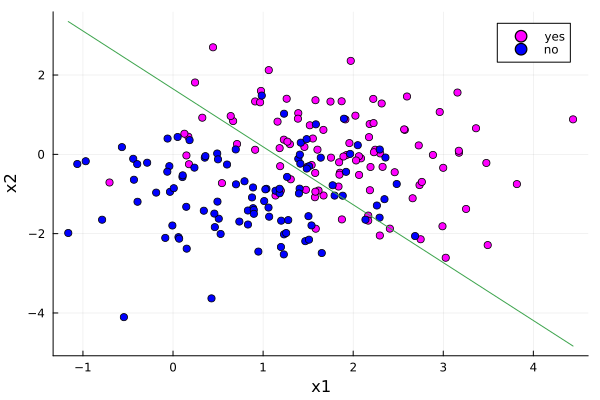

In [14]:
using DataFrames, CSV, LinearAlgebra
using Plots, StatsModels, StatsBase
using JuMP, Ipopt

function svm1(A, y; C=100)  # separable data, but nonlinear constraint
    (m,n) = size(A)
    model = Model(Ipopt.Optimizer)
    @variable(model, M >= 0)       # the margin
    @variable(model, β[1:n])       # model parameters
    @variable(model, s[1:m] >= 0); # slack variables
    @NLconstraint(model, sum(β[i]^2 for i in 2:n) == 1)
    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= M-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m) <= C)
    @objective(model, Max, M)
    optimize!(model)
    println("objective value = ", objective_value(model))
    println("solution = ", value.(β))
    return value.(β)
end

# two-class data
df = CSV.read("/Users/dhondupdolma/Desktop/Data/two-class-data.csv", DataFrame)
fo = @formula(y ~ 1 + x1 + x2)
A = modelmatrix(fo.rhs, df)
y = vec(modelmatrix(fo.lhs, df))

β1 = svm1(A, y; C=25)
println(β1)# obtain the model parameters
f(x) = (-β1[1] - β1[2]*x)/β1[3] 
yes = findall(x->x==1, y)    # indices for the +1 class
no  = findall(x->x==-1, y)   # indices for the -1 class
# plot the data and the decision boundary
scatter(df.x1[yes], df.x2[yes], color=:magenta, label="yes")
scatter!(df.x1[no], df.x2[no], color=:blue, label="no")
plot!(df.x1, f.(df.x1), label="", xlabel="x1", ylabel="x2")

In [15]:
#2a
function svm2(A,y;C=20)
      # separable data, but nonlinear constraint
    (m,n) = size(A)#model matrix
    model = Model(Ipopt.Optimizer)
    @variable(model, β[1:n]) 
    @variable(model, s[1:m]>=0);
    for i in 1:m
        @constraint(model, y[i]*(β'*A[i,:]) >= 1-s[i])
    end
    @constraint(model, sum(s[i] for i in 1:m)<=C)
    @objective(model,Min,sum( β[i]^2 for i in 2:n) )
    optimize!(model)
    println("objective value=",objective_value(model))
    println("solution =", value.(β))
    return value.(β)
end
β = svm2(A, y; C=90) #when C is less than 100 the optimal solution is infeasible
β

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1000
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:      203
                     variables with only lower bounds:      200
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      201
        inequality constraints with only lower bounds:      200
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.90e-01 1.75e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

3-element Vector{Float64}:
 -1.2461976264632695
  1.239636905489155
  0.8076971594462172

In [16]:
#2b 
yest=zeros(200)
for i in 1:200
    yest[i] = y[i]*(β'*A[i,:]) #includes the beta derived from the svm2 hence
end
count =0
for j in 1:200
    if(yest[j] < 0)
        count+=1 
    end
end
count #number of misclassifications

46